# Image Augmentation

In [1]:
%matplotlib inline
import d2l
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
import time

## Setup 

Load a sample image with a shape of $400\times 500$.

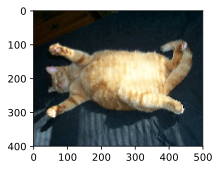

In [2]:
d2l.set_figsize()
img = image.imread('cat1.jpg')
d2l.plt.imshow(img.asnumpy())

### The Drawing Function `show_images`

In [3]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

### Apply an Augmentation Multiple Times and Draw Results  

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=2):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)


## Flip and Crop

### Randomly Flip Left and Right

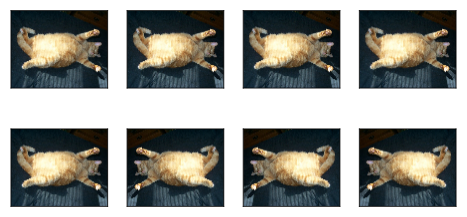

In [5]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

### Randomly Flip Top and Bottom

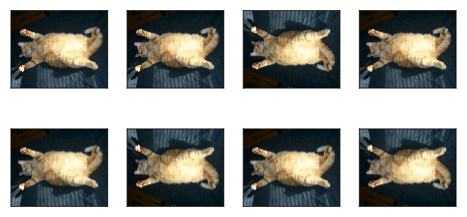

In [6]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())

### Randomly Crop a Region

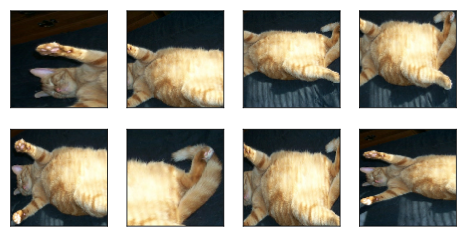

In [7]:
shape_aug = gdata.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

## Color 

### Randomly Change Brightness

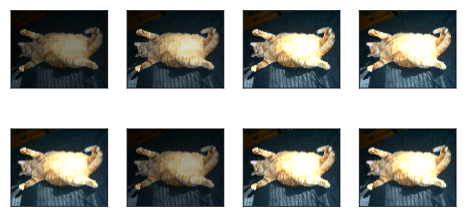

In [8]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

### Randomly Change Hue

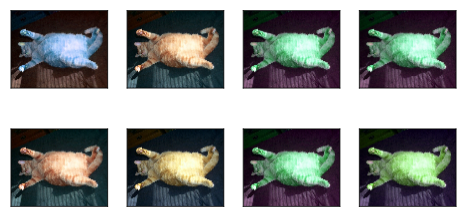

In [9]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

### Randomly Change Brightness, Contrast, Saturation and Hue 

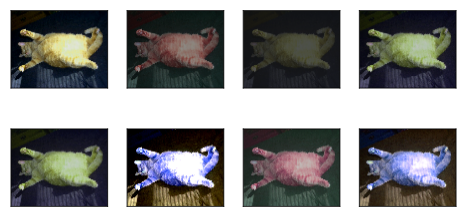

In [10]:
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## Use Multiple Image Augmentation Methods Together 

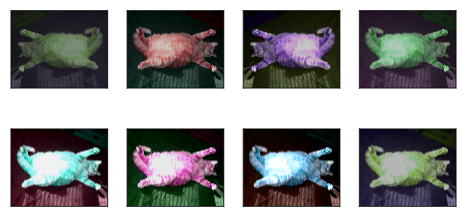

In [21]:
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), 
    gdata.vision.transforms.RandomColorJitter(
        brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    gdata.vision.transforms.RandomResizedCrop(
        (200, 200), scale=(0.1, 1), ratio=(0.5, 2))])
apply(img, augs)

## Using Image Augmentations to Train Models

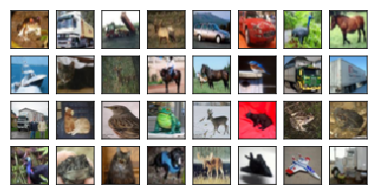

In [12]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8)

train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor()])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()])

### Load Data

In [13]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

### Use Multi-GPUs

In [14]:
def try_all_gpus():  
    ctxes = []
    try:
        for i in range(16): 
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

### Split Data into Multi-GPUs

In [15]:
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

### Evaluate on Multi-GPUs

In [16]:
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n

### Train on Multi-GPUs

In [17]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

### A Function to Train with Various Augmentations

In [18]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=8)

### Train with Image Augmentation

In [19]:
train_with_data_aug(train_augs, test_augs)

('training on', [gpu(0), gpu(1)])
epoch 1, loss 1.4165, train acc 0.498, test acc 0.612, time 39.1 sec
epoch 2, loss 0.8359, train acc 0.702, test acc 0.705, time 35.3 sec
epoch 3, loss 0.6084, train acc 0.787, test acc 0.775, time 35.4 sec
epoch 4, loss 0.4859, train acc 0.831, test acc 0.815, time 35.2 sec
epoch 5, loss 0.3986, train acc 0.862, test acc 0.765, time 35.2 sec
epoch 6, loss 0.3328, train acc 0.885, test acc 0.817, time 35.1 sec
epoch 7, loss 0.2772, train acc 0.904, test acc 0.838, time 35.2 sec
epoch 8, loss 0.2343, train acc 0.919, test acc 0.833, time 35.1 sec


In [20]:
train_with_data_aug(test_augs, test_augs)

('training on', [gpu(0), gpu(1)])
epoch 1, loss 1.3561, train acc 0.518, test acc 0.527, time 35.5 sec
epoch 2, loss 0.7933, train acc 0.720, test acc 0.692, time 35.3 sec
epoch 3, loss 0.5731, train acc 0.799, test acc 0.751, time 35.3 sec
epoch 4, loss 0.4256, train acc 0.850, test acc 0.762, time 35.3 sec
epoch 5, loss 0.3102, train acc 0.892, test acc 0.732, time 35.2 sec
epoch 6, loss 0.2315, train acc 0.919, test acc 0.793, time 35.1 sec
epoch 7, loss 0.1623, train acc 0.943, test acc 0.734, time 35.1 sec
epoch 8, loss 0.1142, train acc 0.960, test acc 0.800, time 35.1 sec
